# CIS 5450 Final Project

Dataset: https://www.kaggle.com/datasets/tsaustin/us-historical-stock-prices-with-earnings-data

In [39]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# Load datasets
prices = pd.read_csv(
    "./datasets/stock_prices_latest.csv",
    parse_dates=["date"],
    dtype={"symbol": str}
)
earnings = pd.read_csv(
    "./datasets/earnings_latest.csv",
    parse_dates=["date"],
    dtype={"symbol": str, "announce_time": str}
)

In [16]:
display(earnings.columns)
display(prices.columns)

Index(['symbol', 'date', 'qtr', 'eps_est', 'eps', 'release_time'], dtype='object')

Index(['symbol', 'date', 'open', 'high', 'low', 'close', 'close_adjusted',
       'volume', 'split_coefficient'],
      dtype='object')

# Cleaning Dataset

In [17]:
# Rename Columns
earnings = earnings.rename(
    columns={
        "date": "earnings_date",
        "eps_est": "consensus_eps",
        "eps": "actual_eps",
        "release_time": "announce_time"
    }
)
display(earnings.columns)

Index(['symbol', 'earnings_date', 'qtr', 'consensus_eps', 'actual_eps',
       'announce_time'],
      dtype='object')

In [18]:
# Drop events missing EPS or announcement time
earnings = earnings.dropna(
    subset=["consensus_eps", "actual_eps", "announce_time"]
).reset_index(drop=True)

# Compute the effective trading date of the event
def effective_trade_date(row):
    # After Market Close (AMC) → next trading day; Before Market Open (BMO) → same day
    if row["announce_time"].upper().startswith("AMC"):
        return row["earnings_date"] + pd.Timedelta(days=1)
    else:
        return row["earnings_date"]

earnings["trade_date"] = earnings.apply(effective_trade_date, axis=1)

In [19]:
# Restrict price data to the relevant date span (±5 days around events)
min_date = earnings["trade_date"].min() - pd.Timedelta(days=5)
max_date = earnings["trade_date"].max() + pd.Timedelta(days=5)
prices = prices[
    (prices["date"] >= min_date) &
    (prices["date"] <= max_date)
].copy()

# Keep only adjusted prices to handle splits/dividends
prices = prices[[
    "symbol", "date", "close_adjusted", "open", "high", "low", "volume"
]]

# Merge earnings events with price data on effective trade date
event_prices = pd.merge(
    earnings[["symbol", "earnings_date", "trade_date", "actual_eps", "consensus_eps"]],
    prices,
    left_on=["symbol", "trade_date"],
    right_on=["symbol", "date"],
    how="inner"
)

# Drop duplicates and reset index
event_prices = event_prices.drop_duplicates(subset=["symbol", "earnings_date"]).reset_index(drop=True)

# Save cleaned data for downstream analysis
event_prices.to_csv("cleaned_event_price_data.csv", index=False)

# Display the shape of the cleaned dataset
event_prices.shape

(79444, 11)

# EDA

In [27]:
df = pd.read_csv("cleaned_event_price_data.csv", parse_dates=["earnings_date", "trade_date", "date"])

# Compute earnings surprise and event-day return
df['surprise'] = df['actual_eps'] - df['consensus_eps']
df['return'] = (df['close_adjusted'] - df['open']) / df['open']

# Create a binary indicator for beat vs. miss
df['beat'] = df['surprise'] > 0

# Extract the year of each earnings date
df['year'] = df['earnings_date'].dt.year

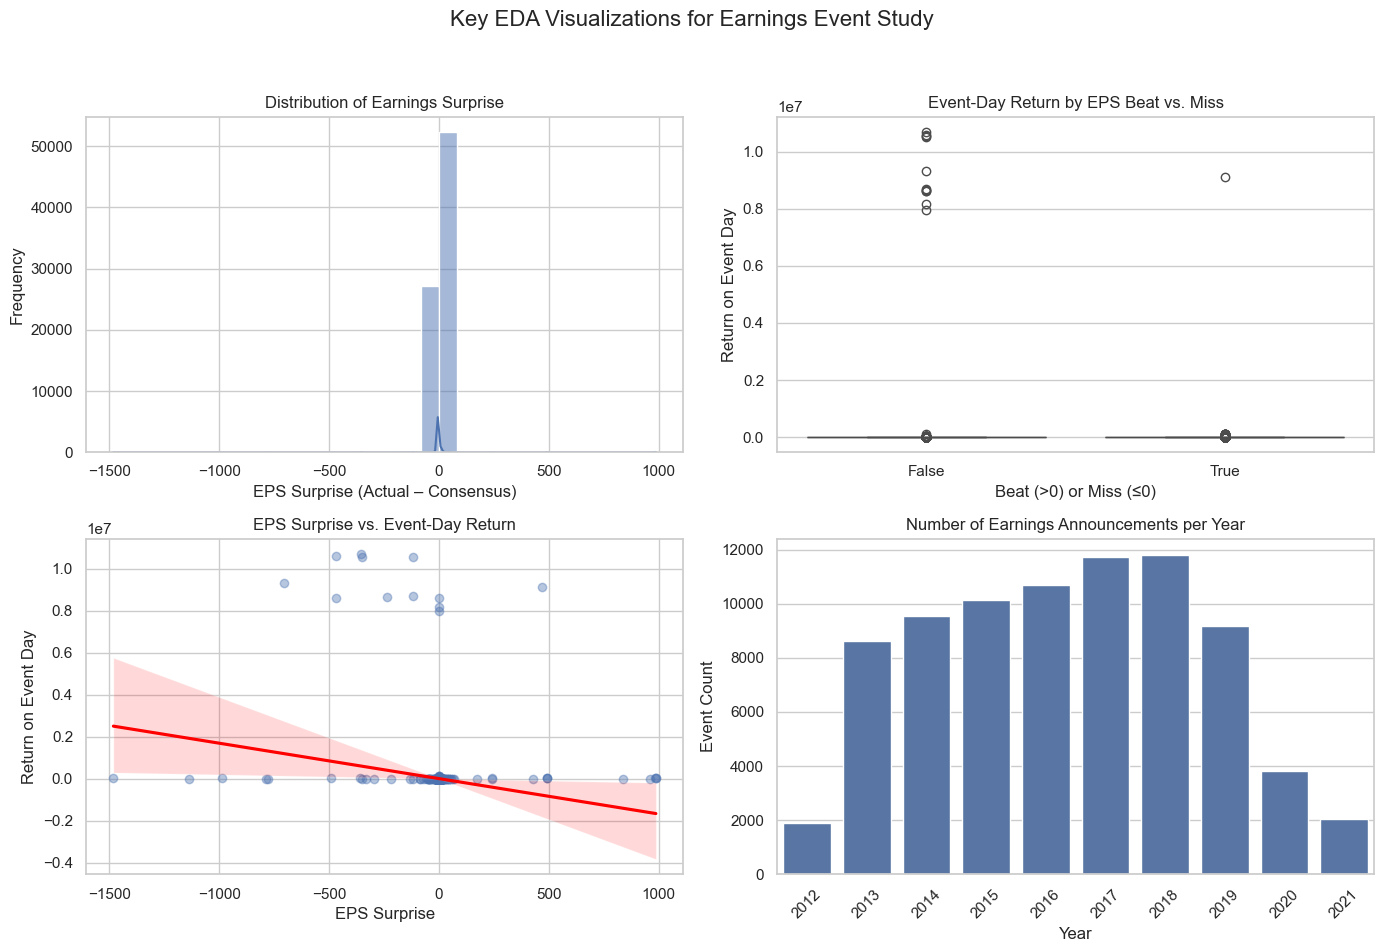

In [29]:
# Set Seaborn style
sns.set(style="whitegrid")

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Key EDA Visualizations for Earnings Event Study", fontsize=16)

# 1. Distribution of Earnings Surprise
sns.histplot(data=df, x='surprise', bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Distribution of Earnings Surprise")
axes[0, 0].set_xlabel("EPS Surprise (Actual – Consensus)")
axes[0, 0].set_ylabel("Frequency")

# 2. Boxplot: Event-Day Return by Beat vs. Miss
sns.boxplot(data=df, x='beat', y='return', ax=axes[0, 1])
axes[0, 1].set_title("Event-Day Return by EPS Beat vs. Miss")
axes[0, 1].set_xlabel("Beat (>0) or Miss (≤0)")
axes[0, 1].set_ylabel("Return on Event Day")

# 3. Scatter with Regression: Surprise vs. Event-Day Return
sns.regplot(data=df, x='surprise', y='return', scatter_kws={'alpha':0.4}, line_kws={'color':'red'}, ax=axes[1, 0])
axes[1, 0].set_title("EPS Surprise vs. Event-Day Return")
axes[1, 0].set_xlabel("EPS Surprise")
axes[1, 0].set_ylabel("Return on Event Day")

# 4. Count of Earnings Events per Year
sns.countplot(data=df, x='year', ax=axes[1, 1])
axes[1, 1].set_title("Number of Earnings Announcements per Year")
axes[1, 1].set_xlabel("Year")
axes[1, 1].set_ylabel("Event Count")
for label in axes[1, 1].get_xticklabels():
    label.set_rotation(45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Models - Baselines

### Always Predict 

In [56]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, confusion_matrix,
    mean_squared_error, mean_absolute_error, classification_report, roc_auc_score
)

In [36]:
df = pd.read_csv(
    "cleaned_event_price_data.csv",
    parse_dates=["earnings_date", "trade_date", "date"]
)

# Compute the intraday event‑day return
df["return"] = (df["close_adjusted"] - df["open"]) / df["open"]

df['target_up'] = df['return'] > 0

In [37]:
# --- Classification Baseline ---
# Majority class prediction
majority_class = df['target_up'].mode()[0]
baseline_clf_preds = np.full(len(df), fill_value=majority_class)

# Metrics
acc = accuracy_score(df['target_up'], baseline_clf_preds)
prec = precision_score(df['target_up'], baseline_clf_preds)
rec = recall_score(df['target_up'], baseline_clf_preds)
cm = confusion_matrix(df['target_up'], baseline_clf_preds)

print("Classification Baseline (Always predict {})".format(
    "Up" if majority_class else "Down"
))
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print("Confusion Matrix:\n", cm)


Classification Baseline (Always predict Down)
Accuracy: 0.660
Precision: 0.000
Recall: 0.000
Confusion Matrix:
 [[52397     0]
 [27047     0]]


/opt/anaconda3/envs/cis5450/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [59]:
# Train/Test split Baseline Classification: 
df_model = df.dropna(subset=["surprise", "log_volume", "target_up"])

# Prepare predictors & target
X = df_model[["surprise", "log_volume"]]
y = df_model["target_up"]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
baseline_preds = np.zeros_like(y_test)  # same “always Down” rule
print("Baseline on Logistic’s Test Set:")
print("  Accuracy:", accuracy_score(y_test, baseline_preds))
print("  Conf Matrix:\n", confusion_matrix(y_test, baseline_preds))
print("  ROC AUC:", roc_auc_score(y_test, np.zeros_like(y_test)))

Baseline on Logistic’s Test Set:
  Accuracy: 0.6595758071621877
  Conf Matrix:
 [[10480     0]
 [ 5409     0]]
  ROC AUC: 0.5


In [38]:
# --- Regression Baseline ---
# Always predict zero return
y_true = df['return'].values
baseline_reg_preds = np.zeros_like(y_true)

mse = mean_squared_error(y_true, baseline_reg_preds)
mae = mean_absolute_error(y_true, baseline_reg_preds)

print("\nRegression Baseline (Always predict 0 return)")
print(f"Mean Squared Error: {mse:.6f}")
print(f"Mean Absolute Error: {mae:.6f}")


Regression Baseline (Always predict 0 return)
Mean Squared Error: 13221639038.342815
Mean Absolute Error: 1425.989777


### Linear Regression

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [42]:
# Read Data
df = pd.read_csv(
    "cleaned_event_price_data.csv",
    parse_dates=["earnings_date", "trade_date", "date"]
)

In [43]:
# Feature Engineering
df["surprise"] = df["actual_eps"] - df["consensus_eps"]
df["log_volume"] = np.log1p(df["volume"])  # log(volume + 1)
df["return"] = (df["close_adjusted"] - df["open"]) / df["open"]

In [44]:
# Drop any rows with missing values in features or target
df_model = df.dropna(subset=["surprise", "log_volume", "return"]).copy()

# --- Prepare Predictors and Target ---
X = df_model[["surprise", "log_volume"]]
y = df_model["return"]

# --- Train/Test Split (80% train, 20% test) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [45]:
# --- Fit Linear Regression ---
lr = LinearRegression()
lr.fit(X_train, y_train)

# --- Predictions and Evaluation ---
y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Linear Regression Performance:")
print(f"  • MSE: {mse:.6f}")
print(f"  • R²:  {r2:.3f}")

Linear Regression Performance:
  • MSE: 19837366869.443577
  • R²:  -0.030


In [47]:
# --- Model Coefficients ---
coeff_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": lr.coef_
})
coeff_df["intercept"] = lr.intercept_
display(coeff_df)

,feature,coefficient,intercept
0,surprise,-2053.701709,-11840.499129
1,log_volume,971.172747,-11840.499129


### Logistic Regression

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, classification_report
)

In [49]:
# Load cleaned event-price data
df = pd.read_csv(
    "cleaned_event_price_data.csv",
    parse_dates=["earnings_date", "trade_date", "date"]
)

In [52]:
# Feature engineering
df["surprise"] = df["actual_eps"] - df["consensus_eps"]
df["log_volume"] = np.log1p(df["volume"])
df["return"] = (df["close_adjusted"] - df["open"]) / df["open"]
df["target_up"] = (df["return"] > 0).astype(int)

In [53]:
# Drop rows with missing values
df_model = df.dropna(subset=["surprise", "log_volume", "target_up"])

# Prepare predictors & target
X = df_model[["surprise", "log_volume"]]
y = df_model["target_up"]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [54]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit logistic regression
lr_clf = LogisticRegression(random_state=42, max_iter=1000)
lr_clf.fit(X_train_scaled, y_train)

# Predictions & evaluation
y_pred = lr_clf.predict(X_test_scaled)
y_proba = lr_clf.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression Classification Metrics:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred):.3f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Down", "Up"]))

Logistic Regression Classification Metrics:
Accuracy:  0.660
Precision: 0.000
Recall:    0.000
ROC AUC:   0.517

Confusion Matrix:
[[10480     0]
 [ 5409     0]]

Classification Report:
              precision    recall  f1-score   support

        Down       0.66      1.00      0.79     10480
          Up       0.00      0.00      0.00      5409

    accuracy                           0.66     15889
   macro avg       0.33      0.50      0.40     15889
weighted avg       0.44      0.66      0.52     15889



/opt/anaconda3/envs/cis5450/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/cis5450/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/cis5450/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/a

In [55]:
# Feature coefficients
coef_df = pd.DataFrame({
    "feature": ["surprise", "log_volume"],
    "coefficient": lr_clf.coef_[0]
})
coef_df["intercept"] = lr_clf.intercept_[0]
coef_df

,feature,coefficient,intercept
0,surprise,-0.010393,-0.661403
1,log_volume,-0.029631,-0.661403
